In [124]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines
from scipy.stats import kde
import matplotlib.colors as clr

In [125]:
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [126]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

In [127]:
#selected = np.where((feh_cal>=-3))
#feh_cal = feh_cal[selected]
#u_g_cal = u_g_cal[selected]
#g_r_cal = g_r_cal[selected]

In [128]:
feh_cal

array([-0.6448489 , -0.95265365, -2.9210906 , ...,  0.08      ,
       -0.43      , -0.32      ], dtype=float32)

In [129]:
u_g_cal

array([1.5318298, 2.0835361, 0.7915249, ..., 1.3973188, 1.9832039,
       1.1543379], dtype=float32)

In [130]:
ret = {}
xedge = {}
yedge = {}
bin = {}

In [131]:
ret['original'],xedge['original'],yedge['original'],bin['original'] = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [132]:
feh_phot = {}
std = {}
error = {}
initial_stars = []
cut_stars = []
#for i, method in enumerate (('original')):
feh_phot['original'] = []
std['original'] = []
error['original'] = []
    


In [135]:

#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(len(objs_new)))
    initial_stars.append(len(objs_new))
    

    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))
    feh_fcn = objs_new["FEH"]
    #make cuts
    '''
    selected = np.where((feh_fcn>=-3))
    feh_fch=feh_fcn[selected]
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
        '''
    u_g = u-g
    g_r = g-r


    #number of stars after cuts
    print("number of stars after cuts: "+str(len(u_g)))
    #cut_stars.append(len(u))
    #stars = len(u)
    
    #original metallicity values from binned_statistic_sd from original calibration sample 
    ind, = np.where(((u_g)>=xedge['original'].min())&((u_g)<=xedge['original'].max())&((g_r)>=yedge['original'].min())&((g_r)<=yedge['original'].max()))
    ix = np.searchsorted(xedge['original'],(u_g)[ind])
    ix = ix - 1
    iy = np.searchsorted(yedge['original'],(g_r)[ind])
    iy = iy - 1
    feh = ret['original'][ix,iy]
    N = np.count_nonzero(~np.isnan(feh))
    #mean_metallicity['original'].append(np.nanmean(feh))
    print("metallicity for original method:",(np.nanmedian(feh)))
    feh_phot['original'].append(feh)
    print(feh_phot['original'])
    std['original'].append(np.nanstd(feh))
    error['original'].append((np.nanstd(feh))/np.sqrt(N))

    return 0


In [136]:
metallicity('/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits')

number of initial stars in field 2770
number of stars after cuts: 2770
metallicity for original method: -0.6895988285541534
[array([-0.76933312, -1.21571374, -2.19931459, ..., -0.10164573,
       -0.67926466, -0.52947795])]


0

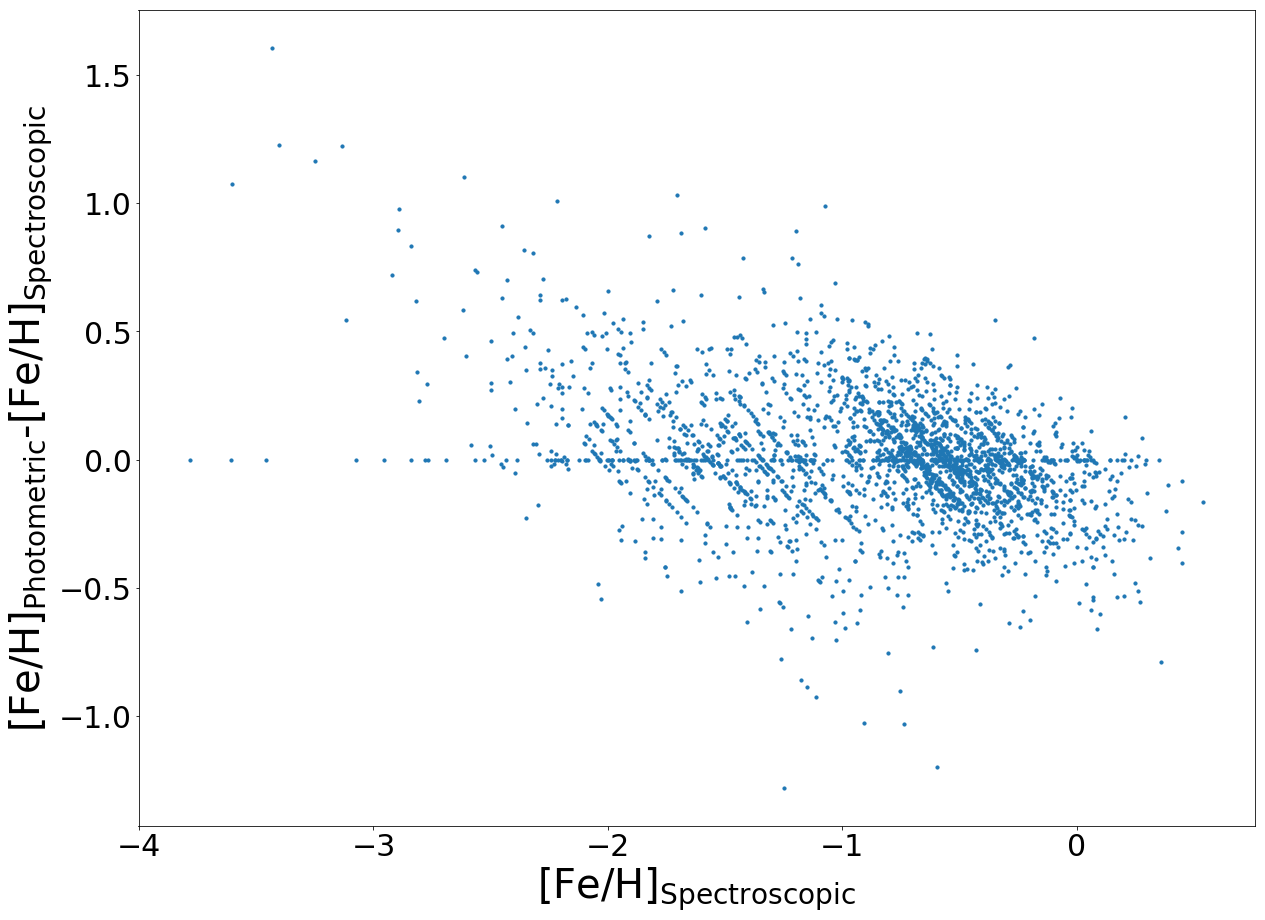

In [137]:
#x axis: [Fe/H]_spec
#y axis: delta [Fe/H]: my values - spectroscopic value: straight line
#the shape tells us about how our my method is doing

delta = feh_phot['original'] - feh_cal

fig, ax = plt.subplots(figsize=(20,15))

ax.scatter(feh_cal,delta,s=10)
plt.xlabel('[Fe/H]$_\mathregular{Spectroscopic}$',fontsize=40)
plt.ylabel('[Fe/H]$_\mathregular{Photometric}$-[Fe/H]$_\mathregular{Spectroscopic}$',fontsize=40)
        

ax.tick_params(axis='both', which='major', labelsize=30)


In [138]:
feh_phot['offset'] = [i + 0.6 for i in feh_phot['original']]

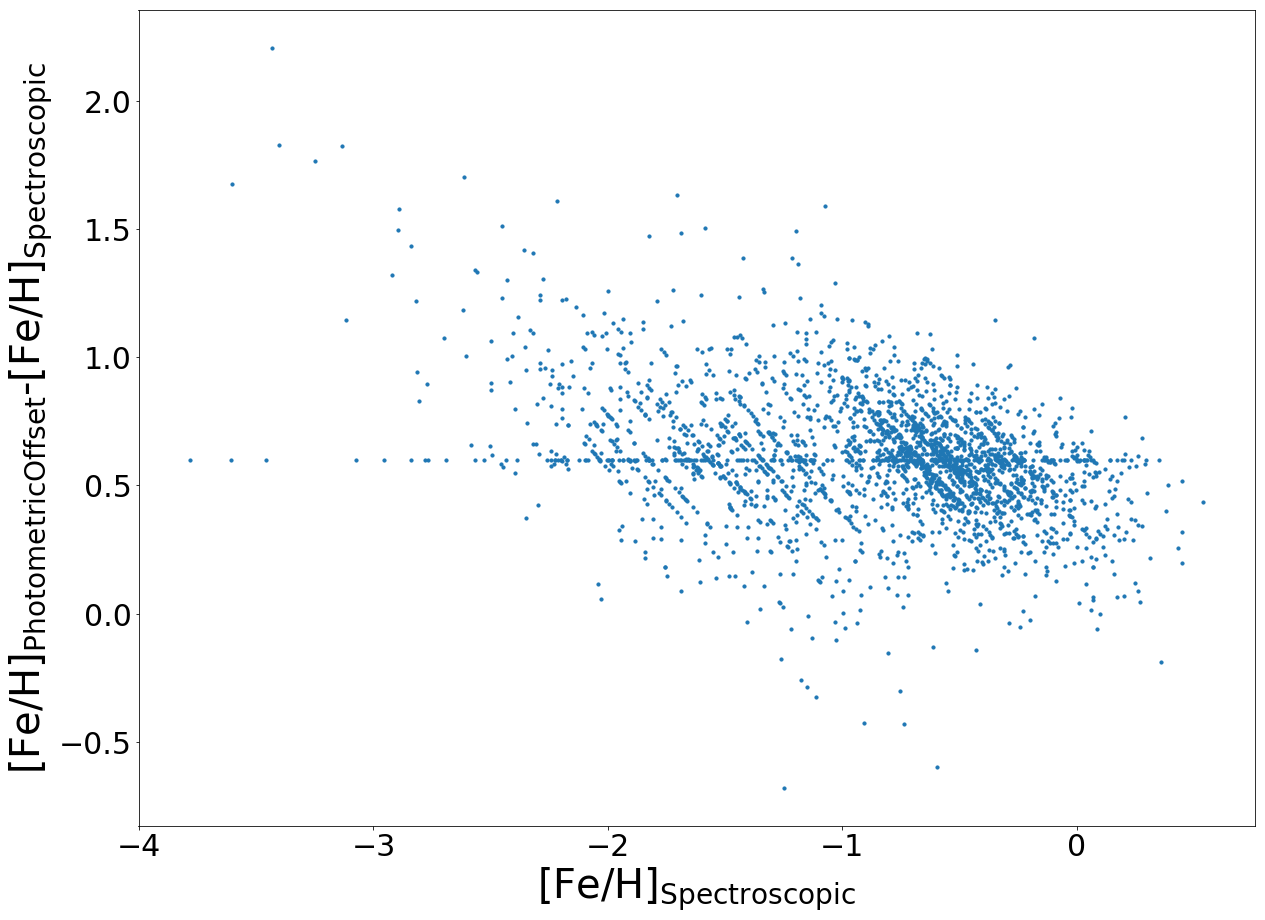

In [140]:
#x axis: [Fe/H]_spec
#y axis: delta [Fe/H]: my values - spectroscopic value: straight line
#the shape tells us about how our my method is doing

delta = feh_phot['offset'] - feh_cal

fig, ax = plt.subplots(figsize=(20,15))

ax.scatter(feh_cal,delta,s=10)
plt.xlabel('[Fe/H]$_\mathregular{Spectroscopic}$',fontsize=40)
plt.ylabel('[Fe/H]$_\mathregular{PhotometricOffset}$-[Fe/H]$_\mathregular{Spectroscopic}$',fontsize=40)
        

ax.tick_params(axis='both', which='major', labelsize=30)



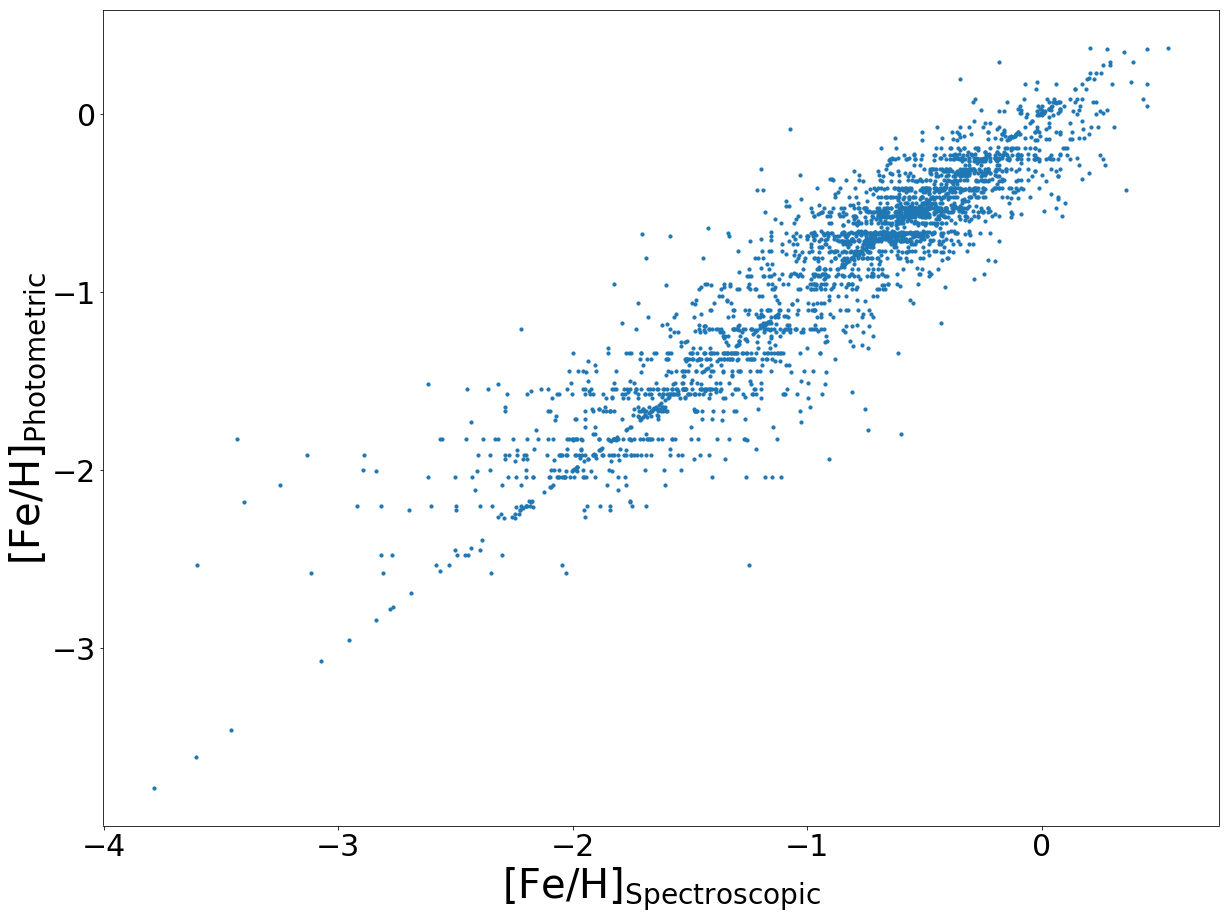

In [145]:
fig, ax = plt.subplots(figsize=(20,15))


ax.scatter(feh_cal,feh_phot['original'],s=10)
plt.xlabel('[Fe/H]$_\mathregular{Spectroscopic}$',fontsize=40)
plt.ylabel('[Fe/H]$_\mathregular{Photometric}$',fontsize=40)
        

ax.tick_params(axis='both', which='major', labelsize=30)